# A-GEM

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import AGEM
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda, device

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin
from base_code.seed import set_seed

# Constants

In [5]:
TORCH_DEVICE = device("cuda" if cuda.is_available() else "cpu")
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/agem.pkl"
set_seed(EXPERIMENT_SEED)

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [8]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "patterns_per_exp": [1, 2, 5, 10],
    "sample_size": [32, 64, 128, 256],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[AGEM] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = AGEM(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Training model 1/16
Training model 2/16
Training model 3/16
Training model 4/16
Training model 5/16
Training model 6/16
Training model 7/16
Training model 8/16
Training model 9/16
Training model 10/16
Training model 11/16
Training model 12/16
Training model 13/16
Training model 14/16
Training model 15/16
Training model 16/16


In [9]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [10]:
best_hyperparameters

{'patterns_per_exp': 10, 'sample_size': 32}

## Evaluation metrics definition

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [12]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [13]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = AGEM(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 127.73it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.2000
	Loss_MB/train_phase/train_stream/Task000 = 1.1184
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6724
100%|██████████| 469/469 [00:03<00:00, 128.90it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 109.6000
	Loss_MB/train_phase/train_stream/Task000 = 0.9030
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6386
100%|██████████| 469/469 [00:03<00:00, 128.07it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 48.4000
	Loss_MB/train_phase/train_stream/Task000 = 0.7669
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6608
100%|██████████| 469/469 [00:03<00:00, 127.45it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_s

 10%|█         | 1/10 [00:26<03:58, 26.52s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.6043
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14a56ff10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [00:56<03:49, 28.63s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0100
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14ac6b880>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:28<03:30, 30.02s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4280
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14aff2bb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [02:02<03:10, 31.77s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4417
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14b3260a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [02:33<02:37, 31.58s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.0731
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14cb7ce50>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [03:06<02:06, 31.75s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.9023
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14cce8e20>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.7370, 0.8274, 0.8650, 0.9057, 0.9241, 0.9413, 0.0933, 0.1476, 0.1173,
         0.1144],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [03:40<01:37, 32.50s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7905
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14f539ca0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.7370, 0.8274, 0.8650, 0.9057, 0.9241, 0.9413, 0.0933, 0.1476, 0.1173,
         0.1144],
        [0.7307, 0.7903, 0.8024, 0.8800, 0.8873, 0.9192, 0.9417, 0.1394, 0.1111,
         0.1327],
    

 80%|████████  | 8/10 [04:13<01:05, 32.74s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.4949
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1619bd070>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.7370, 0.8274, 0.8650, 0.9057, 0.9241, 0.9413, 0.0933, 0.1476, 0.1173,
         0.1144],
        [0.7307, 0.7903, 0.8024, 0.8800, 0.8873, 0.9192, 0.9417, 0.1394, 0.1111,
         0.1327],
    

 90%|█████████ | 9/10 [04:46<00:32, 32.95s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6058
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x161db17f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.7370, 0.8274, 0.8650, 0.9057, 0.9241, 0.9413, 0.0933, 0.1476, 0.1173,
         0.1144],
        [0.7307, 0.7903, 0.8024, 0.8800, 0.8873, 0.9192, 0.9417, 0.1394, 0.1111,
         0.1327],
    

100%|██████████| 10/10 [05:20<00:00, 32.01s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5535
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1621645e0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 6320.0576
	EvalStream/Acc_Matrix = 
tensor([[0.9138, 0.1731, 0.1298, 0.1478, 0.1286, 0.0988, 0.1123, 0.0873, 0.1374,
         0.1220],
        [0.8969, 0.9252, 0.1414, 0.1272, 0.1418, 0.0903, 0.1079, 0.1036, 0.1323,
         0.1659],
        [0.8783, 0.9017, 0.9338, 0.0992, 0.1009, 0.1131, 0.0730, 0.1056, 0.1097,
         0.1430],
        [0.8279, 0.8765, 0.9100, 0.9359, 0.0816, 0.0864, 0.0884, 0.1150, 0.0935,
         0.1270],
        [0.7875, 0.8649, 0.8925, 0.9102, 0.9394, 0.0957, 0.0778, 0.1161, 0.1241,
         0.1516],
        [0.7370, 0.8274, 0.8650, 0.9057, 0.9241, 0.9413, 0.0933, 0.1476, 0.1173,
         0.1144],
        [0.7307, 0.7903, 0.8024, 0.8800, 0.8873, 0.9192, 0.9417, 0.1394, 0.1111,
         0.1327],
    

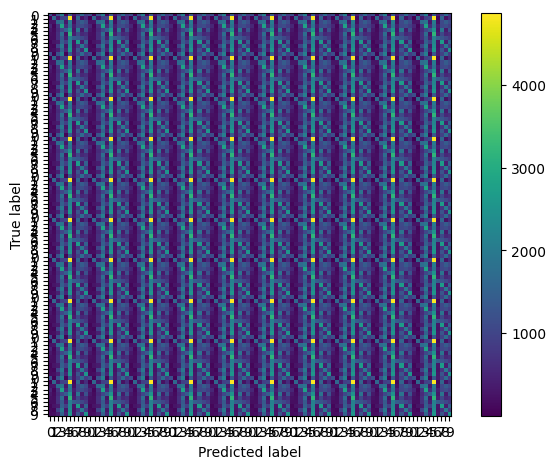

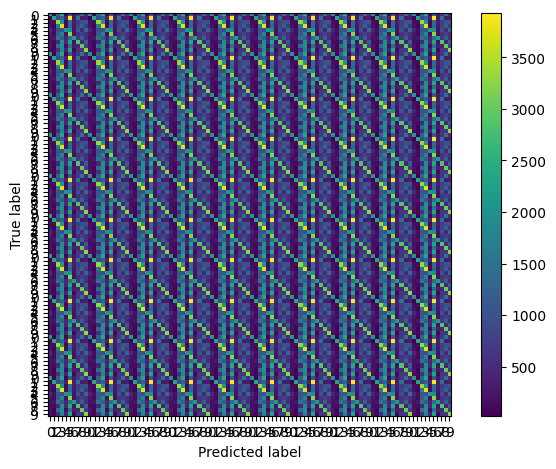

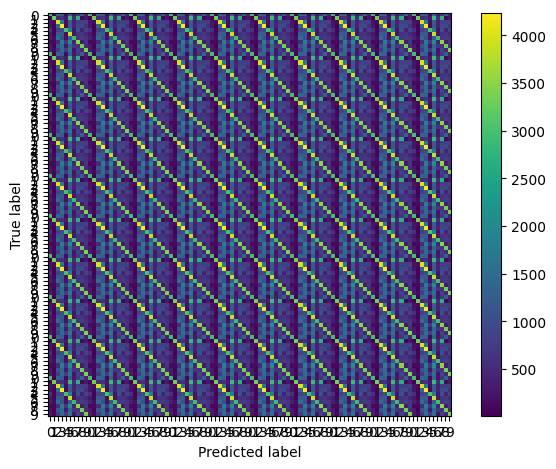

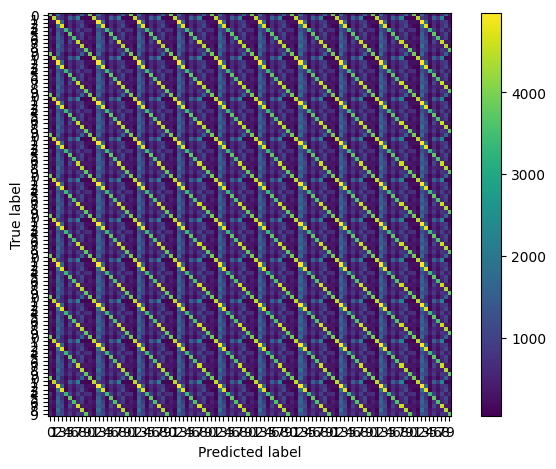

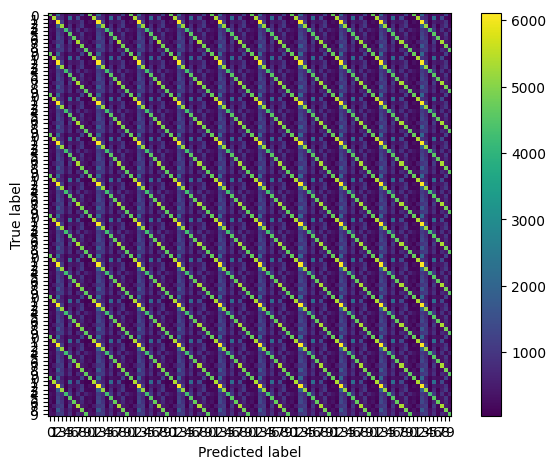

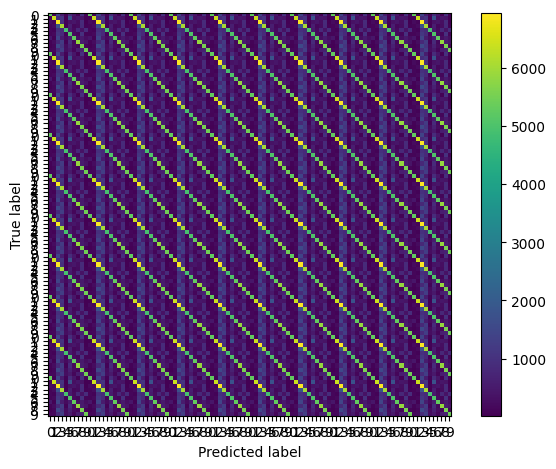

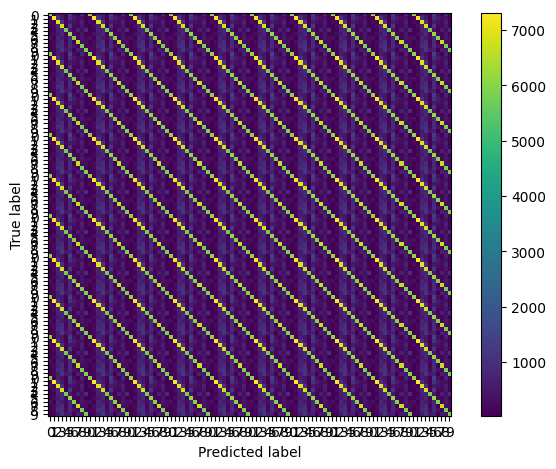

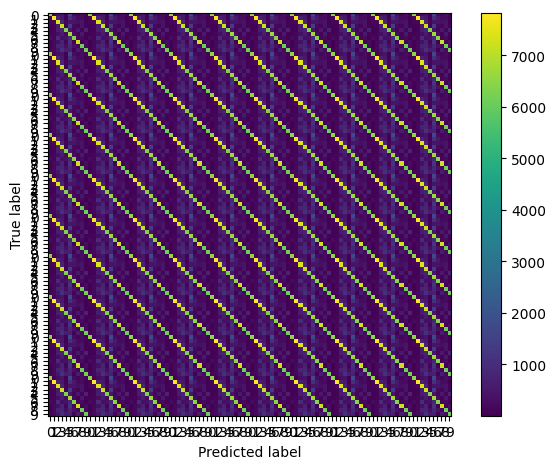

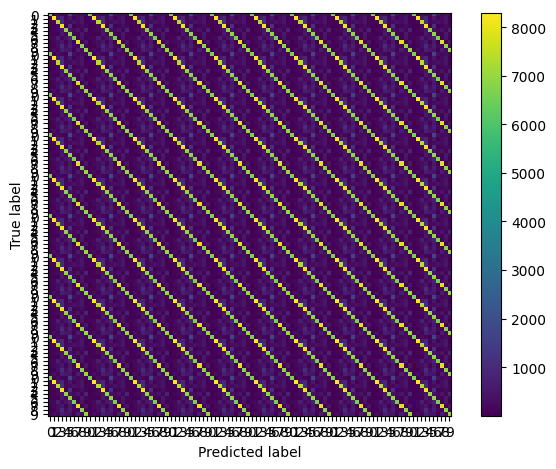

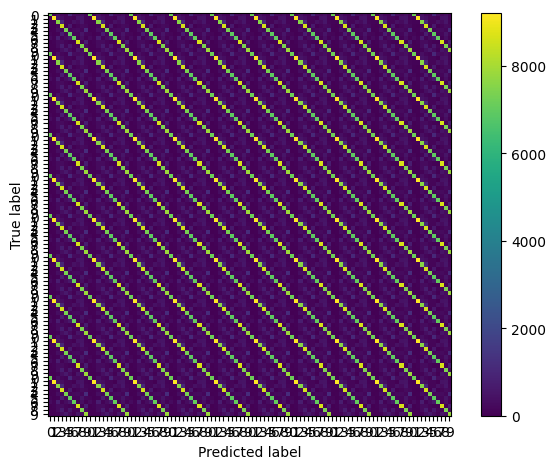

In [14]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [15]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [16]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [17]:
weights = model_plugins[0].weights

# Store metrics

In [18]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))